**Задание
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).**

**У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности.** 

**Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.** 

**Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.**

Описание данных

 - order_id - id заказа
 - delivery_time - время доставки в минутах
 - district - район доставки
 - experiment_group - экспериментальная группа

In [33]:
#Загружаем необходимые библиотеки

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats

In [3]:
# Считываем данные из .csv файла

df = pd.read_csv('experiment_lesson_4.csv')

In [7]:
# Проверяем информацию о ДФ

df

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


In [9]:
# Проверяем уникальные значения в колонке experiment_group

df.experiment_group.unique()

array(['control', 'test'], dtype=object)

In [23]:
# Проверяем уникальные значения в колонке district

df.district.unique()

array(['Purlieus', 'Central', 'Suburb'], dtype=object)

**Для начала давайте сформулируем гипотезы для проверки. Выберите статистические гипотезы, которые мы сможем проверить в этом эксперименте:**

 - ~~Альтернативная гипотеза (H1): Разницы между средним временем доставки в тестовой и контрольной нет~~
 - Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет **(+)**
 - ~~Нулевая гипотеза (H0): Изменение алгоритма не влияет на скорость доставки~~
 - Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть **(+)**
 - ~~Нулевая гипотеза (H0): Разница между средним временем доставки в тестовой и контрольной группе есть~~
 - ~~Альтернативная гипотеза (H1): Изменение алгоритма влияет на скорость доставки~~

**Сопоставьте графики распределения и  экспериментальные группы**

In [10]:
# Настройка графиков по умолчанию
sns.set(
    font_scale =1.5,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,20)}
)

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

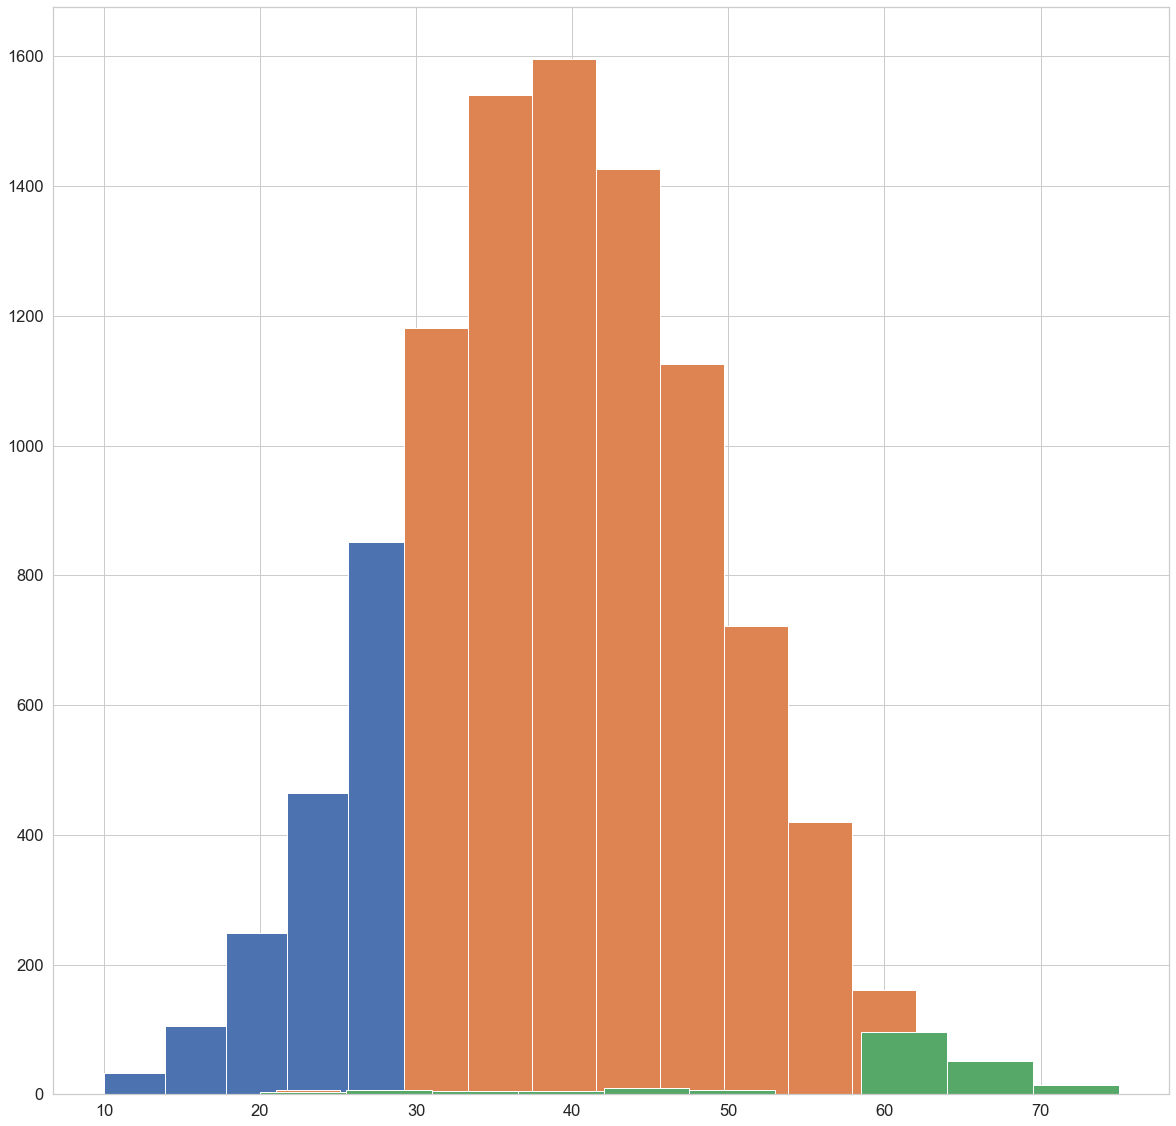

In [24]:
# Строим графики распределения с разделением на експериментальные группы и группировкой по district

df.query("experiment_group == 'test'").groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

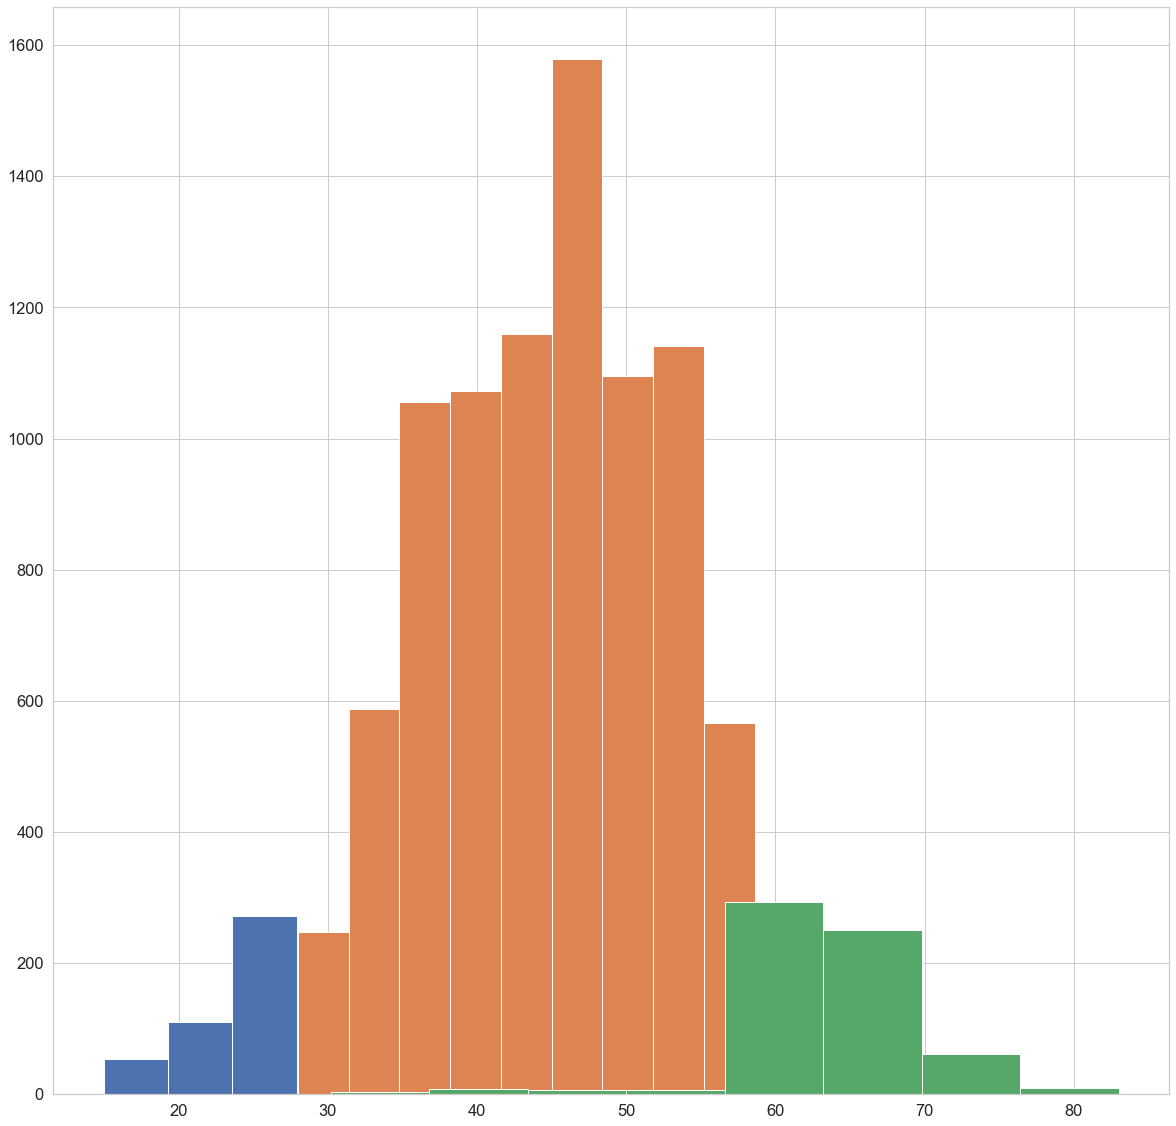

In [25]:
df.query("experiment_group == 'control'").groupby('district').delivery_time.hist()

**Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?**

In [27]:
df.experiment_group.value_counts().max()-df.experiment_group.value_counts().min()

12

**Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.**

**Обязательно сделайте семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), так как на больших выборках вы можете получать неверные результаты.**

**Чувствительность любого теста зависит от размера выборки. Это касается и теста Шапиро-Уилка - на больших выборках он детектирует даже самые незначительные отклонения от нормальности. Поэтому мы берём случайные 1000 значений из выборки, чтобы обойти этот недостаток.**

**Есть шанс, что случайные 1000 значений всё же сформируют ненормальное распределение, поэтому рекомендуем использовать аргумент `random_state=17` для стабильности и воспроизводимости результатов.**

In [44]:
# Создаем рандомные выборки для групп

test = df[df['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)
control = df[df['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17)

In [34]:
# Проверяем нормальность распределения в сформированных группах с использованием теста Шапиро-Уилка

stats.shapiro(test)

ShapiroResult(statistic=0.9975479245185852, pvalue=0.14013493061065674)

In [35]:
stats.shapiro(control)

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

In [40]:
# Считаем значения стандартного отклонения для групп test и control

np.std(df[df['experiment_group'] == 'test']['delivery_time']).round(2)

9.88

In [41]:
np.std(df[df['experiment_group'] == 'control']['delivery_time']).round(2)

9.99

**Пришло время сравнить средние в тесте и контроле. Внимание: здесь уже не нужно пользоваться методом .sample() — он нам нужен был только для теста Шапиро-Уилка, остальные тесты надо проводить на полных данных.**

In [46]:
# Считаем значение статистики и p-значимости

stats.ttest_ind(df[df['experiment_group'] == 'test']['delivery_time'],
                df[df['experiment_group'] == 'control']['delivery_time'])

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

**На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлите до сотых)?**

In [51]:
((df[df['experiment_group'] == 'test']['delivery_time'].mean() - df[df['experiment_group'] == 'control']['delivery_time'].mean()) / df[df['experiment_group'] == 'control']['delivery_time'].mean() * 100).round(2) 

-13.35

**Что в итоге? Катим?**

 - Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле. **(+)**
 - ~~Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте больше, чем в контроле.~~
 - ~~Не катим, так как среднее время доставки статистически значимо не изменилось.~~
 - ~~Да, раскатываем на всех, новый алгоритм напрямую влияет на скорость доставки.~~